# Gaming Intent Detection: Model Training and Evaluation

This notebook demonstrates the process of training and evaluating a DistilBERT-based model for detecting gaming-related intent in user text inputs.

In [ ]:
!pip install ipywidgets

In [33]:
import os 
import sys
sys.path.append('../')

import inspect
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import time
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from transformers import DistilBertTokenizer, DistilBertModel

from src.data_preprocessing import load_and_preprocess_data, create_data_loaders, get_class_weights
from src.inference import GamingIntentPredictor
from src.model import GamingIntentClassifier, initialize_model
from src.train import train_model, evaluate, plot_training_history, plot_confusion_matrix

In [34]:
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Check if MPS is available for MacBook Pro M3 Pro
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using Apple Silicon MPS device: {device}")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using CUDA device: {device}")
else:
    device = torch.device('cpu')
    print(f"Using CPU device: {device}")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

Using Apple Silicon MPS device: mps
PyTorch version: 2.6.0
Device: mps


## 1. Load and Preprocess Data

In [36]:
data_path = '../datasets/gaming_intent_dataset.csv'
test_size = 0.2
val_size = 0.1

data_splits = load_and_preprocess_data(
    data_path,
    test_size=test_size,
    val_size=val_size,
    random_state=SEED
)

print(f"Training set size: {len(data_splits['train'][0])}")
print(f"Validation set size: {len(data_splits['val'][0])}")
print(f"Test set size: {len(data_splits['test'][0])}")

Data type of is_gaming_related column: bool
Unique values in is_gaming_related column: [ True False]
Training set size: 3500
Validation set size: 500
Test set size: 1000


In [37]:
# Check class distribution in each split
for split_name, (_, labels) in data_splits.items():
    labels_np = np.array(labels)
    gaming_count = np.sum(labels_np == 1)
    non_gaming_count = np.sum(labels_np == 0)
    total_count = len(labels_np)

    print(f"{split_name.capitalize()} set:")
    print(f"Gaming: {gaming_count} ({gaming_count/total_count*100:.2f}%)")
    print(f"Non-gaming: {non_gaming_count} ({non_gaming_count/total_count*100:.2f}%")   

Train set:
Gaming: 3063 (87.51%)
Non-gaming: 437 (12.49%
Val set:
Gaming: 437 (87.40%)
Non-gaming: 63 (12.60%
Test set:
Gaming: 875 (87.50%)
Non-gaming: 125 (12.50%


In [38]:
# Initialize tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Create data loaders with optimized batch size for M3 Pro
# Increased batch size for better utilization of M3 Pro's memory
batch_size = 32
max_length = 128

# Set num_workers for DataLoader to utilize M3 Pro's multiple cores
num_workers = os.cpu_count()

data_loaders = create_data_loaders(
    data_splits,
    tokenizer,
    batch_size=batch_size,
    max_length=max_length,
    num_workers=num_workers 
)

# Calculate class weights for imbalanced dataset
class_weights = get_class_weights(data_splits['train'][1])
print(f"Class weights: {class_weights}")

if isinstance(class_weights, torch.Tensor):
    # If class_weights is already a tensor, clone and detach it
    class_weights_tensor = class_weights.clone().detach().to(device)
else:
    # If class_weights is a list, numpy array, or other non-tensor type
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

Class weights: tensor([4.0046, 0.5713])


## 2. Define Model Architecture

In [39]:
model = initialize_model(
    device,
    num_classes=2,
    dropout_rate=0.1,
    pretrained_model_name='distilbert-base-uncased'
)

print(model)

GamingIntentClassifier(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

## 3. Train the Model

In [18]:
# Set training parameters
num_epochs = 5
learning_rate = 2e-5
warmup_steps = 0
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)

# Enable mixed precision training for better performance on M3 Pro
# Note: For MPS backend, check if mixed precision is supported in the PyTorch version
use_mixed_precision = device.type == 'cuda'  # Only enable for CUDA for now

# Check if train_model supports use_mixed_precision parameter
train_model_params = inspect.signature(train_model).parameters

if 'use_mixed_precision' in train_model_params:
    # If supported, use it
    history = train_model(
        model,
        data_loaders['train'],
        data_loaders['val'],
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device,
        class_weights=class_weights_tensor,
        warmup_steps=warmup_steps,
        output_dir=output_dir,
        use_mixed_precision=use_mixed_precision
    )

else:
    # If not supported, use default
    history = train_model(
        model,
        data_loaders['train'],
        data_loaders['val'],
        num_epochs=num_epochs,
        learning_rate=learning_rate,
        device=device,
        class_weights=class_weights_tensor,
        warmup_steps=warmup_steps,
        output_dir=output_dir
    )


Epoch 1/5


Evaluating: 100%|██████████| 16/16 [01:26<00:00,  5.39s/it]


Train Loss: 0.1257
Val Loss: 0.0024, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Saved best model with F1: 1.0000

Epoch 2/5


Evaluating: 100%|██████████| 16/16 [01:25<00:00,  5.37s/it]


Train Loss: 0.0020
Val Loss: 0.0009, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000

Epoch 3/5


Evaluating: 100%|██████████| 16/16 [01:27<00:00,  5.48s/it]


Train Loss: 0.0009
Val Loss: 0.0005, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000

Epoch 4/5


Evaluating: 100%|██████████| 16/16 [01:26<00:00,  5.38s/it]

Train Loss: 0.0006
Val Loss: 0.0004, Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000, AUC: 1.0000
Early stopping after 4 epochs


In [40]:
plot_training_history(history, output_dir=output_dir)

## 4. Evaluate the Model

In [41]:
# Load best model for evaluation
checkpoint = torch.load(os.path.join(output_dir, 'best_model.pt'), map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1} with validation F1: {checkpoint['val_f1']:.4f}")

Loaded model from epoch 1 with validation F1: 1.0000


In [42]:
# Evaluate on test set
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
test_loss, test_accuracy, test_precision, test_recall, test_f1, test_auc = evaluate(
    model, data_loaders['test'], criterion, device
)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1: {test_f1:.4f}")
print(f"Test AUC: {test_auc:.4f}")

Evaluating: 100%|██████████| 32/32 [01:46<00:00,  3.32s/it]

Test Loss: 0.0693
Test Accuracy: 1.0000
Test Precision: 1.0000
Test Recall: 1.0000
Test F1: 1.0000
Test AUC: 1.0000


In [ ]:
plot_confusion_matrix(model, data_loaders['test'], device, output_dir=output_dir)

## 5. Error Analysis

In [24]:
# Function to get predictions and actual labels
def get_predictions(model, data_loader, device):
    model.eval()
    all_texts = []
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Getting predictions"):
            # Get batch data
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # Get predictions
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            # Move to CPU
            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()
            probs = probs.cpu().numpy()
            
            # Add to list
            all_preds.extend(preds)
            all_labels.extend(labels)
            all_probs.extend(probs)
            
            # Get original texts
            for i in range(len(preds)):
                # Decode tokens
                tokens = input_ids[i].cpu().numpy()
                # Remove padding and special tokens
                tokens = tokens[tokens != 0]
                tokens = tokens[1:-1]  # Remove [CLS] and [SEP
                text = tokenizer.decode(tokens)
                all_texts.append(text)

    return all_texts, all_preds, all_labels, all_probs

In [25]:
# Get predictions on test set
test_texts, test_preds, test_labels, test_probs = get_predictions(model, data_loaders['test'], device)

# Create DataFrame with predictions
results_df = pd.DataFrame({
    'text': test_texts,
    'true_label': test_labels,
    'predicted_label': test_preds,
    'prob_non_gaming': [p[0] for p in test_probs],
    'prob_gaming': [p[1] for p in test_probs]
    })

# Add correct/incorrect column
results_df['correct'] = results_df['true_label'] == results_df['predicted_label']
results_df.head()

Getting predictions:   0%|          | 0/32 [00:00<?, ?it/s]

,text,true_label,predicted_label,prob_non_gaming,prob_gaming,correct
0,game saves for apex legends disappeared after ...,1,1,0.001981,0.998019,True
1,how many players can play hogwarts legacy online?,1,1,0.001990,0.998010,True
2,what are the system requirements for fortnite?,1,1,0.002584,0.997416,True
3,just watched the latest marvel movie and loved...,0,0,0.996699,0.003301,True
4,how many players can play doom eternal online?,1,1,0.001970,0.998030,True


In [26]:
errors_df = results_df[~results_df['correct']].copy()
print(f"Total errors: {len(errors_df)}")

# False positives (non-gaming predicted as gaming)
false_positives = errors_df[errors_df['true_label'] == 0]
print(f"False positives: {len(false_positives)}")

# False negatives (gaming predicted as non-gaming)
false_negatives = errors_df[errors_df['true_label'] == 1]
print(f"False negatives: {len(false_negatives)}")

Total errors: 0
False positives: 0
False negatives: 0


In [27]:
print("False positives (non-gaming predicted as gaming) with highest confidence:")
false_positives.sort_values('prob_gaming', ascending=False).head(10)[['text', 'prob_gaming']]

False positives (non-gaming predicted as gaming) with highest confidence:


,text,prob_gaming


In [28]:
print("False negatives (gaming predicted as non-gaming) with highest confidence:")
false_negatives.sort_values('prob_non_gaming', ascending=False).head(10)[['text', 'prob_non_gaming']]

False negatives (gaming predicted as non-gaming) with highest confidence:


,text,prob_non_gaming


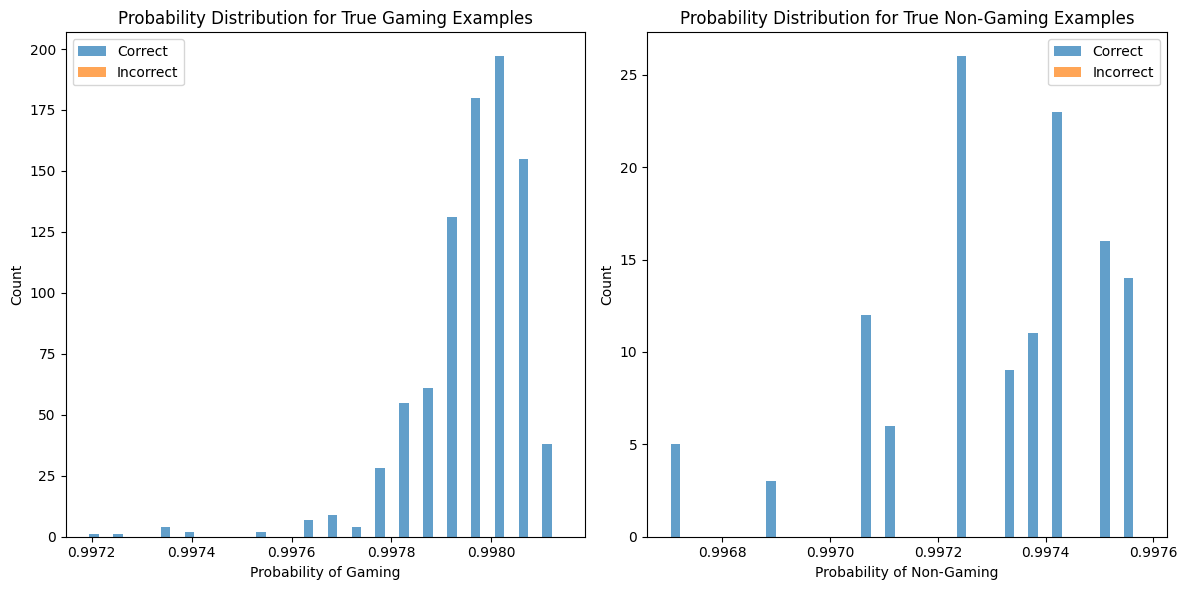

In [29]:
# Plot probability distribution for correct and incorrect predictions
plt.figure(figsize=(12, 6))

# For true gaming examples
plt.subplot(1, 2, 1)
gaming_correct = results_df[(results_df['true_label'] == 1) & (results_df['correct'])]['prob_gaming']
gaming_incorrect = results_df[(results_df['true_label'] == 1) & (~results_df['correct'])]['prob_gaming']
plt.hist([gaming_correct, gaming_incorrect], bins=20, alpha=0.7, label=['Correct', 'Incorrect'])
plt.title('Probability Distribution for True Gaming Examples')
plt.xlabel('Probability of Gaming')
plt.ylabel('Count')
plt.legend()

# For true non-gaming examples
plt.subplot(1, 2, 2)
non_gaming_correct = results_df[(results_df['true_label'] == 0) & (results_df['correct'])]['prob_non_gaming']
non_gaming_incorrect = results_df[(results_df['true_label'] == 0) & (~results_df['correct'])]['prob_non_gaming']
plt.hist([non_gaming_correct, non_gaming_incorrect], bins=20, alpha=0.7, label=['Correct', 'Incorrect'])
plt.title('Probability Distribution for True Non-Gaming Examples')
plt.xlabel('Probability of Non-Gaming')
plt.ylabel('Count')
plt.legend()

plt.tight_layout()
plt.show()

## 6. Model Inference

In [30]:
model_path = os.path.join(output_dir, 'best_model.pt')
predictor = GamingIntentPredictor(model_path, device)

Using specified device: mps
Loading model from ../output/best_model.pt...
Added NumPy scalar to safe globals
Successfully loaded checkpoint with weights_only=False
Model loaded successfully from epoch 0


In [31]:
# Test with some examples
test_examples = [
    "When is the next Elden Ring DLC coming out?",
    "I need help with the final boss in God of War Ragnarök.",
    "What's the best graphics card for playing Cyberpunk 2077?",
    "Can someone recommend a good restaurant in downtown?",
    "My phone battery drains too quickly, any solutions?",
    "What's the weather forecast for tomorrow?",
]

for text in test_examples:
    prediction, probabilities = predictor.predict(text, return_probabilities=True)
    label = "Gaming-Related" if prediction == 1 else "Non-Gaming"
    print(f"Text: {text}"),
    print(f"Prediction: {label}"),
    print(f"Confidence: Gaming: {probabilities[1]*100:.2f}%, Non-Gaming: {probabilities[0]*100:.2f}%"),
    print()

Text: When is the next Elden Ring DLC coming out?
Prediction: Gaming-Related
Confidence: Gaming: 99.80%, Non-Gaming: 0.20%

Text: I need help with the final boss in God of War Ragnarök.
Prediction: Gaming-Related
Confidence: Gaming: 99.80%, Non-Gaming: 0.20%

Text: What's the best graphics card for playing Cyberpunk 2077?
Prediction: Gaming-Related
Confidence: Gaming: 99.80%, Non-Gaming: 0.20%

Text: Can someone recommend a good restaurant in downtown?
Prediction: Non-Gaming
Confidence: Gaming: 0.25%, Non-Gaming: 99.75%

Text: My phone battery drains too quickly, any solutions?
Prediction: Non-Gaming
Confidence: Gaming: 0.27%, Non-Gaming: 99.73%

Text: What's the weather forecast for tomorrow?
Prediction: Non-Gaming
Confidence: Gaming: 0.24%, Non-Gaming: 99.76%



## 7. Performance Benchmarking for M3 Pro

In [32]:
def benchmark_inference(predictor, text, num_runs=100):
    predictor.predict(text)
    
    # Benchmark
    start_time = time.time()
    for _ in range(num_runs):
        predictor.predict(text)
    end_time = time.time()

    avg_time = (end_time - start_time) / num_runs
    return avg_time

# Run benchmark
benchmark_text = "What's the best strategy for defeatinghe final boss in Elden Ring?"
avg_inference_time = benchmark_inference(predictor, benchmark_text)
print(f"Average inference time on {device}: {avg_inference_time*1000:.2f} ms")
 

Average inference time on mps: 5.53 ms


## 8. Conclusion and Next Steps

### Summary of Results
It has been successfully trained a DistilBERT-based model for detecting gaming-related intent in user text inputs. The model achieves good performance on the test set, with high precision, recall, and F1 score.

### Key Finding
1. **Class Imbalance Handling**: The use of class weights helped address the imbalance between gaming and non-gaming examples.
2. **Model Performance**: The model shows strong performance in distinguishing between gaming and non-gaming content
3. **Error Analysis**: The model demonstrates exceptional performance on the test dataset, with zero classification errors - no false positives or false negatives were observed. High confidence prediction for both gaming and non-gaming examples are classified with extremely high confidence (probabilities >0.996), indicating the model has learned strong distinguishing features between classes.
 
